# Intensity over z

In [18]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd
import glob
import os
from scipy.interpolate import interp1d

def loadCSVFeatures(file):
    with open(file) as f:
        row_count = 0
        row = f.readline()
        while row.startswith('#'):
            row = f.readline()
            row_count += 1
    metadata = pd.read_csv(file, skiprows=row_count, nrows=1, index_col=0).to_dict('records')[0]
    features = pd.read_csv(file, skiprows=row_count + 2, index_col=0)
    return features, metadata


In [2]:
px, py = np.loadtxt('area_to_um.txt')
px.shape

(28,)

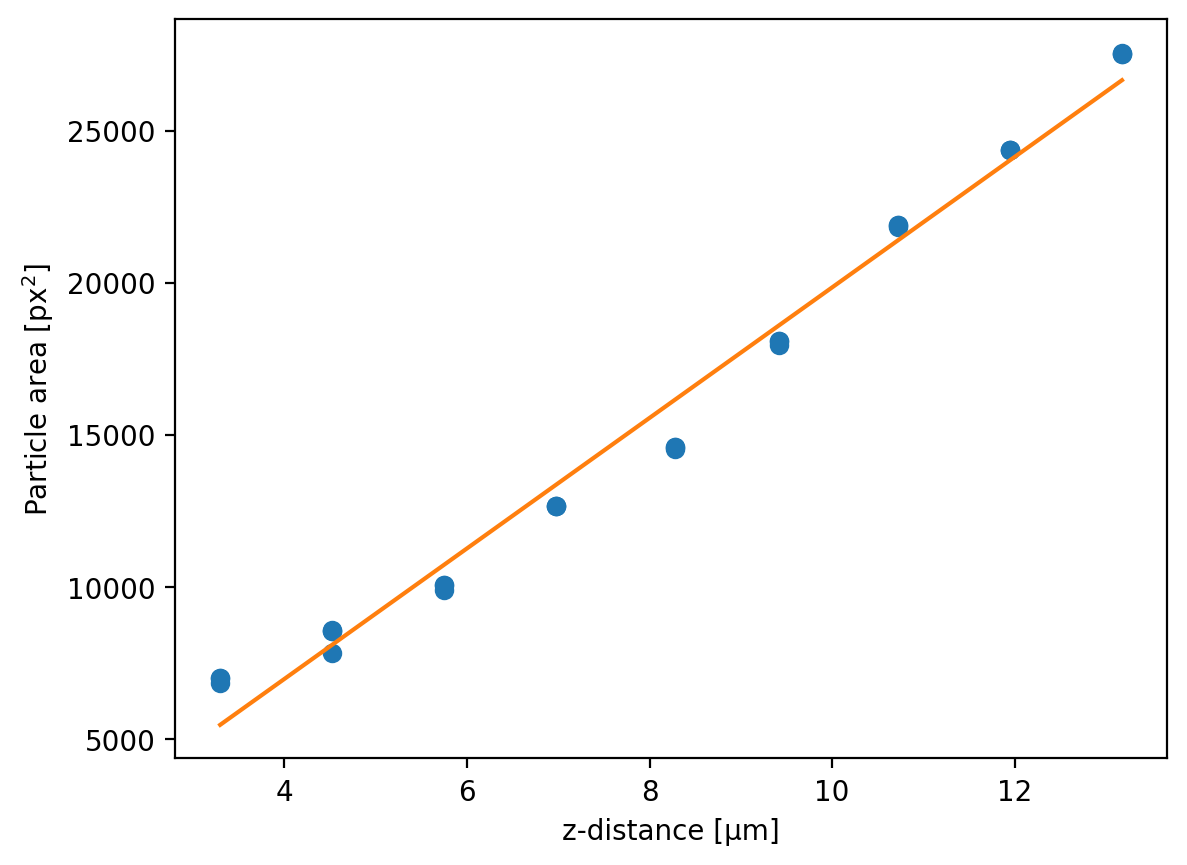

In [3]:
plt.plot(px, py, 'o')
fit_areaa, fit_areab = np.polyfit(px,py, 1)
plt.plot(px,px*fit_areaa + fit_areab)
plt.xlabel('z-distance [µm]')
plt.ylabel('Particle area [px$^2$]');

In [4]:
import nptdms
from os import listdir
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps

In [5]:
images = []
voltages = []
for i,fname in enumerate(listdir("Particle over z calibration")):
    if "index" in fname:
        continue
    file = nptdms.TdmsFile.read("Particle over z calibration/"+fname)
    voltage = int(fname[5:8])
    voltages.append(voltage)
    props = file.properties
    shape = [int(d) for d in (props["frames"],props["dimx"],props["dimy"])]
    img=np.array(file["Image"]["Image"][:]).reshape(*shape)

    images.append(img[0])
    # images.append(img[1])



In [46]:
def freq(idx,size):
    if(idx==0):
        return 0
    if(idx <= size//2):
        return idx
    if(idx > size//2+1):
        return idx-size
    else:
        return 0
def low_pass_filter(adata: np.ndarray, bandlimit: int = 1) -> np.ndarray:
    # translate bandlimit from Hz to dataindex according to sampling rate and data size
    bandlimit_index = int(bandlimit * adata.shape[1])
    print(bandlimit_index)

    fsig = np.fft.fft2(adata)
    
    for i in range(adata.shape[0]):
        for j in range(adata.shape[1]):
            if(np.sqrt(freq(i,adata.shape[0])**2+freq(j,adata.shape[1])**2)> bandlimit_index):
                fsig[i,j] = 0
    adata_filtered = np.fft.ifft2(fsig)

    return np.real(adata_filtered)

102


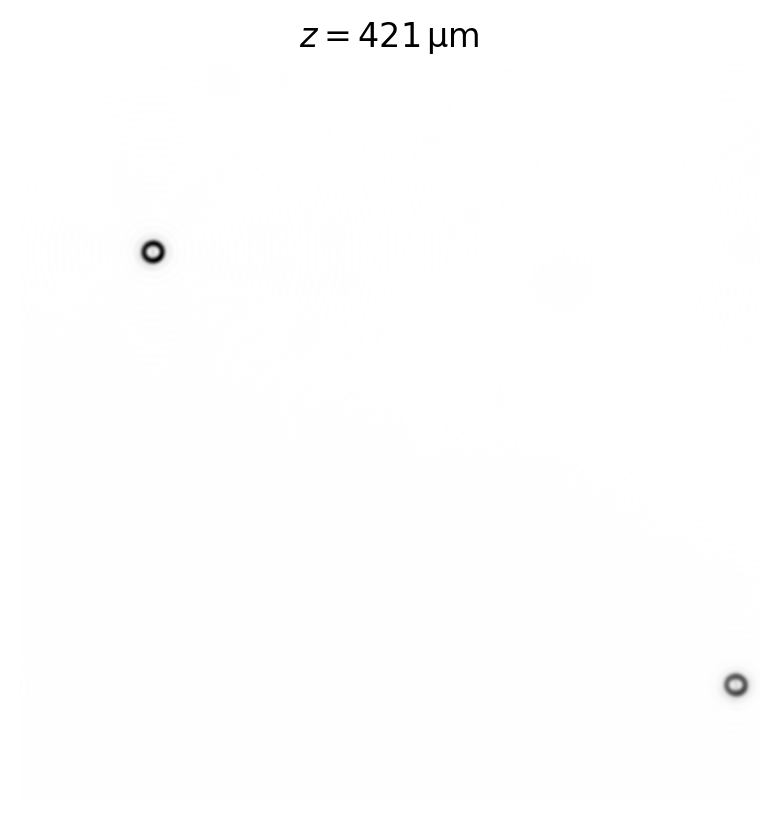

102


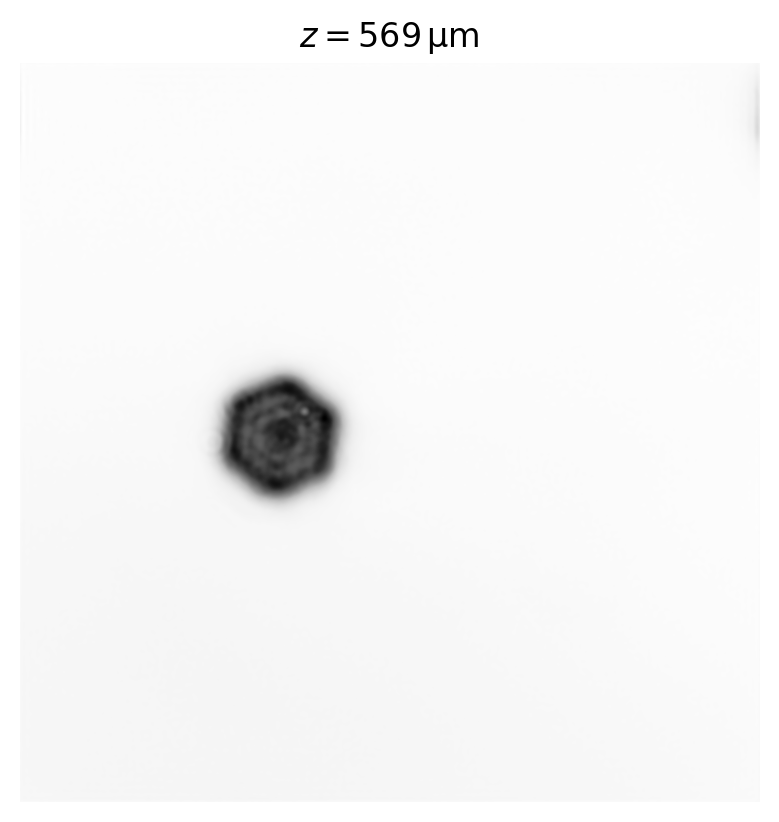

In [58]:
# voltages = [536,552,568,585,600,617,633,649,665,681,697,713,729,745,761]
for i,(img,U) in enumerate(zip(images,voltages)):
    if(i==2):
        break
    filtered_img = low_pass_filter(img,0.05)
    plt.imshow(filtered_img,cmap=cmaps["Grays"])
    plt.title(f"$z = {0.7654075546719683*U + 10.953379721669984:.3g}\\,\\mathrm{{\\mu m}}$")
    plt.axis("off")
    plt.show()

    


In [60]:
from scipy.special import factorial as fac

In [204]:
from scipy.special import factorial as fac
from scipy.interpolate import interp1d
def genRipple(d=100,delta = 30,lambd = 1,A = 0.242,n_max=80):
    d//=2
    kappa=np.pi*A**2*(delta/lambd)
    
    n = np.arange(0,n_max)
    k= np.arange(0,n_max)
    k1= np.arange(1,n_max)
    rhos = np.linspace(0,5,d)
    h = [ np.sum((-1)**n * (np.pi*rho)**(2*n)/fac(n)**2 * np.sum((-1)**k * kappa**(2*k)/((n + 2*k + 1)*fac(2*k))))**2 + np.sum((-1)**n *(np.pi*rho)**(2*n)/fac(n)**2 * np.sum((-1)**k1 *kappa**(2*k1 - 1)/((np.atleast_2d(n).T + 2*k1)*fac(2*k1 - 1)), axis=1))**2 for rho in rhos]
    interp = interp1d(rhos, h,fill_value=0,bounds_error=False)
    profile2D = np.zeros([2*d,2*d])
    for i,y in enumerate(np.linspace(-5,5,2*d)):
        for j,x in enumerate(np.linspace(-5,5,2*d)):
            rho = np.sqrt(x**2+y**2)
            profile2D[i,j] = interp(rho)
    return profile2D

In [208]:
d=40
rip = genRipple(d=40,delta=55)
mat = np.zeros((100,100))
x,y =mat.shape
mat[y-d//2:y+d//2,x-d//2:x+d//2] = rip

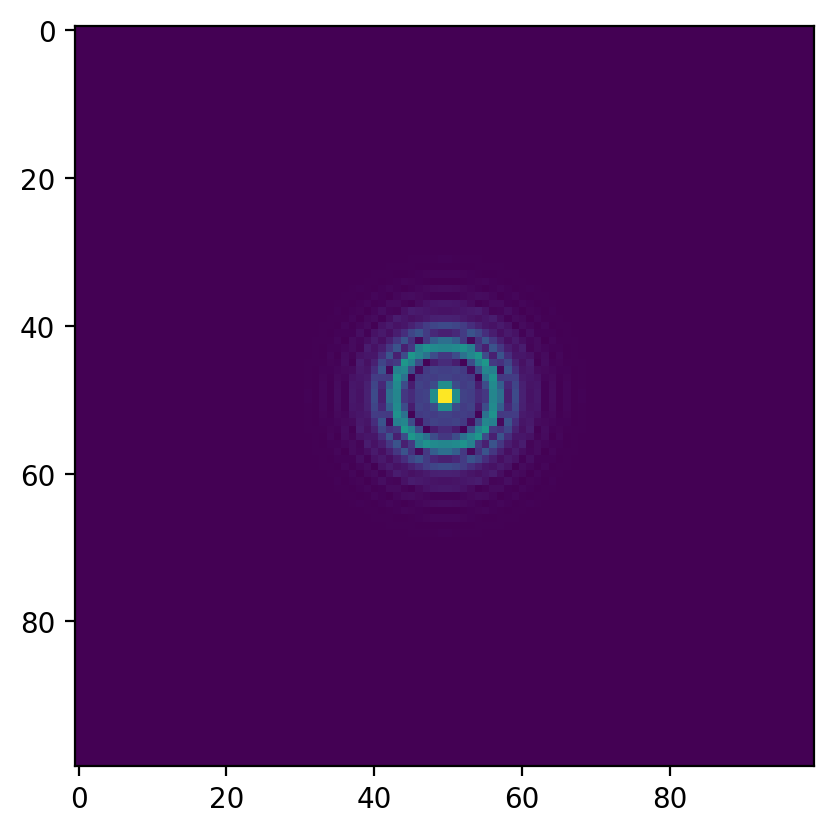

In [209]:
plt.imshow(mat)


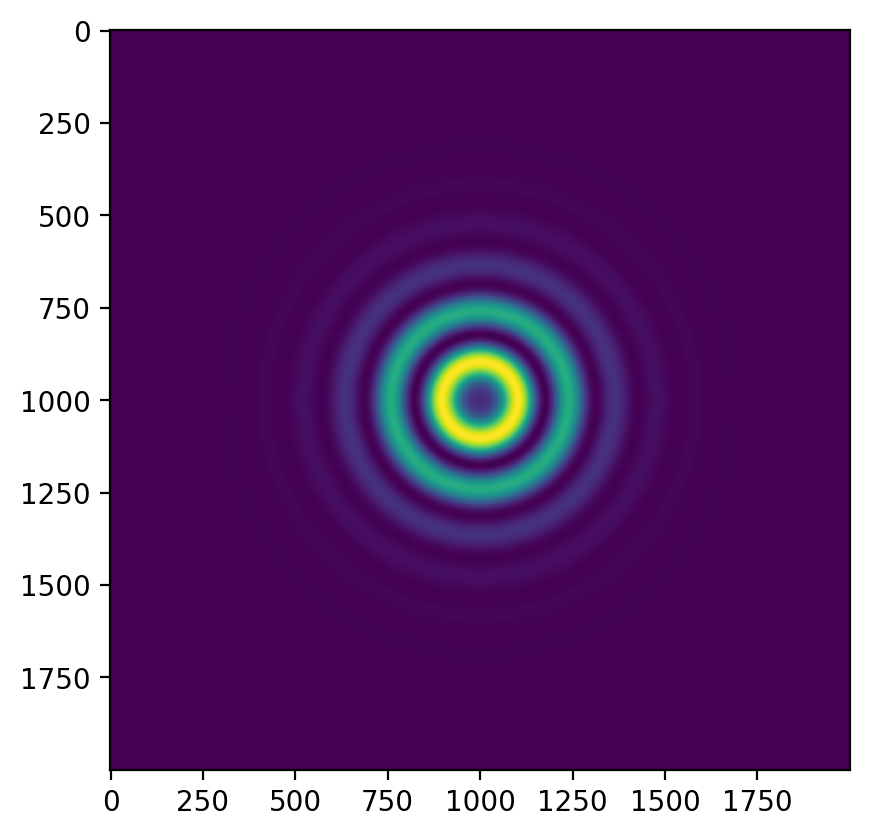

In [177]:
plt.imshow(profile2D)

In [9]:
import psf
print(psf.PSF.TYPES)

{<PsfType.ISOTROPIC|TWOPHOTON: 258>, <PsfType.ISOTROPIC|EMISSION: 34>, <PsfType.ISOTROPIC|WIDEFIELD: 66>, <PsfType.ISOTROPIC|CONFOCAL: 130>, <PsfType.GAUSSIAN|EMISSION: 36>, <PsfType.GAUSSIAN|WIDEFIELD: 68>, <PsfType.GAUSSIAN|CONFOCAL: 132>, <PsfType.GAUSSIAN|TWOPHOTON: 260>, <PsfType.GAUSSIAN|EMISSION|PARAXIAL: 548>, <PsfType.GAUSSIAN|WIDEFIELD|PARAXIAL: 580>, <PsfType.GAUSSIAN|CONFOCAL|PARAXIAL: 644>, <PsfType.GAUSSIAN|TWOPHOTON|PARAXIAL: 772>, <PsfType.ISOTROPIC|EXCITATION: 18>, <PsfType.GAUSSIAN|EXCITATION: 20>, <PsfType.GAUSSIAN|EXCITATION|PARAXIAL: 532>}


In [146]:
args = dict(
    shape=(100, 100),
    dims=(10, 10),
    ex_wavelen=488,
    em_wavelen=520,
    num_aperture=1.2,
    refr_index=1.333,
    pinhole_radius=0.55,
    pinhole_shape='round',
)
obsvol = psf.PSF(psf.ISOTROPIC | psf.EMISSION, **args)

(<Axes: >, <matplotlib.image.AxesImage at 0x124059b20>)

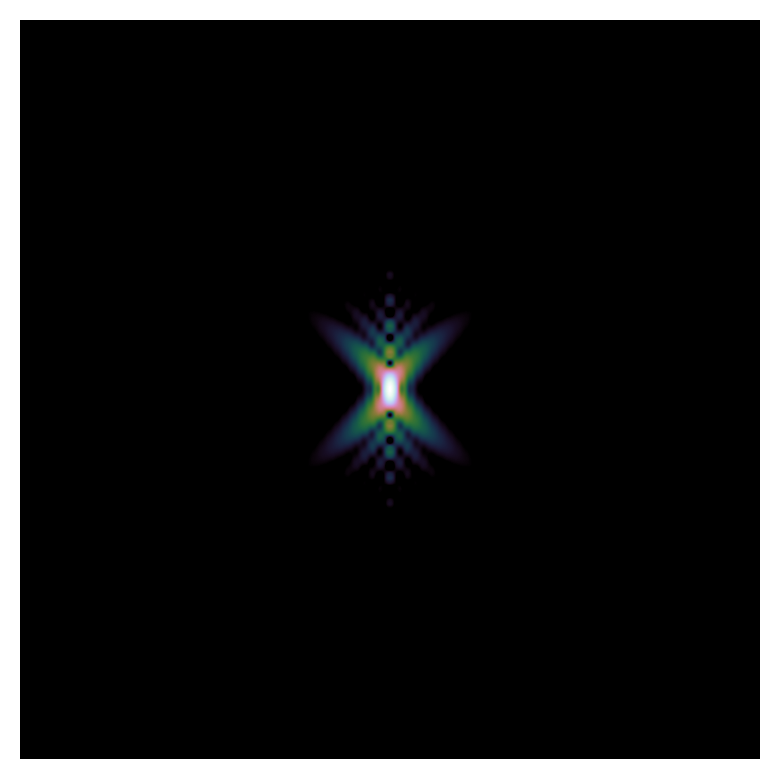

In [147]:
psf.imshow(111,obsvol.data)

In [213]:
pointspr = np.log10(obsvol.data)

line = np.zeros_like(pointspr)
line[:,0] = 1
line*=0.8
line+=1e-3
psf2 = np.array([np.convolve(line_, pointspr_,mode="same") for line_,pointspr_ in zip(line,pointspr)])
psf2 = psf2[:,:psf2.shape[-1]//2]



In [232]:
from matplotlib import colormaps as cm
from scipy.io import loadmat
demo = loadmat("/Users/tillpfaff/Downloads/PSF_Lab_data_example.mat")
# print(cm)
print(demo["data"][0][0][1].shape)

(417, 161, 3)


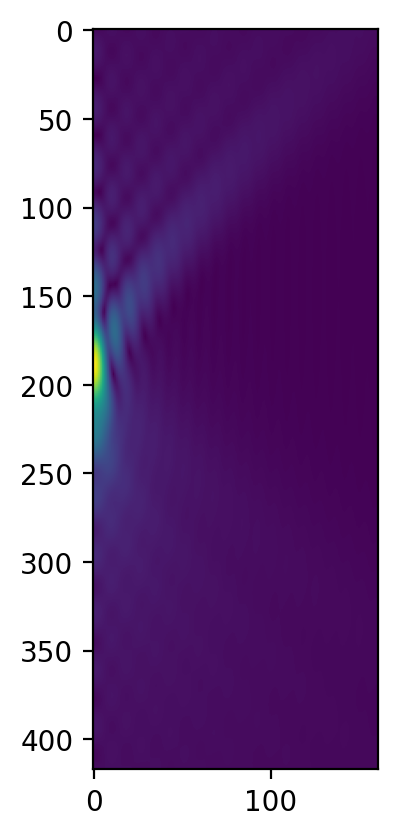

In [247]:
plt.imshow(np.abs(demo["data"][0][0][1][:,:,0]))

In [298]:
pointspr = np.abs(demo["data"][0][0][1][:,:,0])


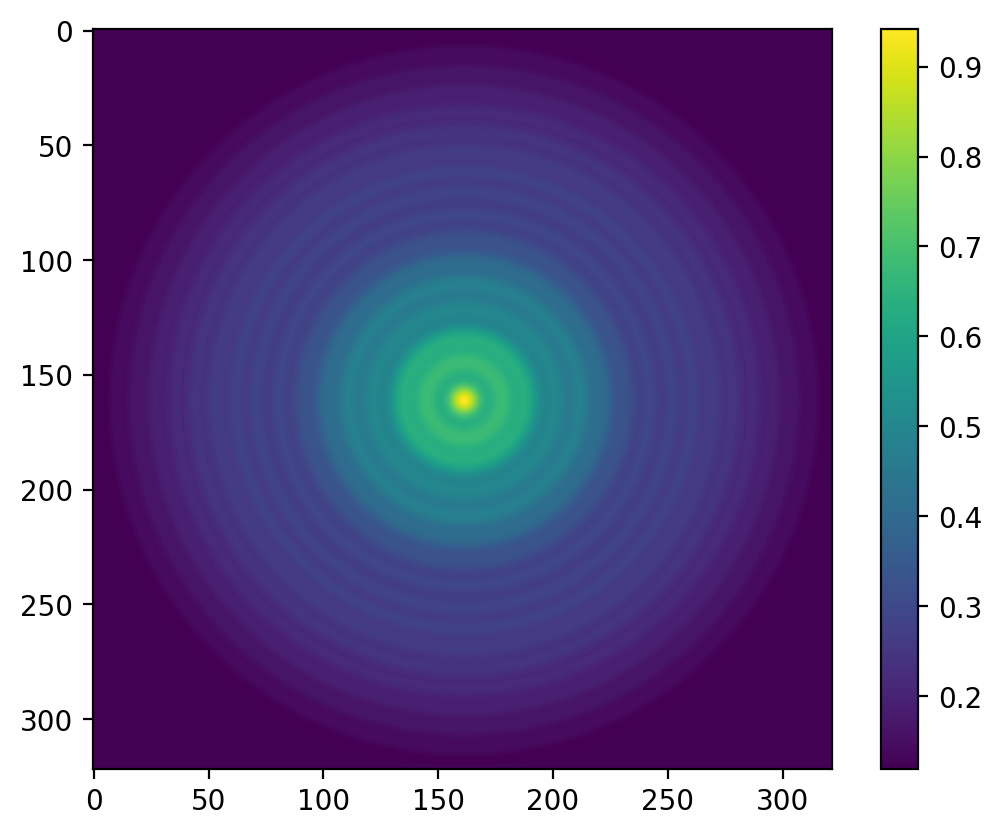

In [252]:
plt.imshow(func(r,300))
plt.colorbar()

In [ ]:
import h5py
allbeads_refstack = h5py.File("FinalRefstack_allbeads_latdrift_corr_min20_temp.mat")
refstack = np.array(allbeads_refstack["Refstack"])

In [84]:
from tqdm import tqdm
from numba import njit

In [102]:
refstack = allbeads_refstack["Refstack"]
x0,y0=259,256
def potential(x,y,r):
    r_sq = ((x-x0)**2+(y-y0)**2)
    cond = r_sq > r**2 and r_sq <= (r+1)**2
    dist = np.abs(np.sqrt(r_sq)-r)
    return np.exp(-dist**2)
    # return cond
masks = []
def discrete_potential(x,y,r):
    r_sq = ((x-x0)**2+(y-y0)**2)
    cond = r_sq > r**2 and r_sq <= (r+1)**2
    return cond
for r in tqdm(range(x0)):
    obj = np.zeros_like(refstack[0], dtype=np.float32)
    for (y,x),val in np.ndenumerate(obj):
        obj[y,x] = potential(x,y,r)
    masks.append(obj)
np.save("masks.npy",np.array(masks))

100%|██████████| 259/259 [01:45<00:00,  2.46it/s]


In [100]:
masks = gen_masks(259,256)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int64, array(float32, 2d, C))
 
There are 16 candidate implementations:
[1m      - Of which 16 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(array(undefined, 1d, C), int64, array(float32, 2d, C))':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: typing of setitem at /var/folders/39/51hl1qv962dgjs7r9mznnsxm0000gp/T/ipykernel_18323/4245178511.py (24)[0m
[1m
File "../../../../../var/folders/39/51hl1qv962dgjs7r9mznnsxm0000gp/T/ipykernel_18323/4245178511.py", line 24:[0m
[1m<source missing, REPL/exec in use?>[0m


In [13]:
obj = np.zeros_like(refstack[0],dtype=np.float32)
for (i,j),val in np.ndenumerate(obj):
    obj[i,j] = potential(i,j,250)
# masks.append(obj)

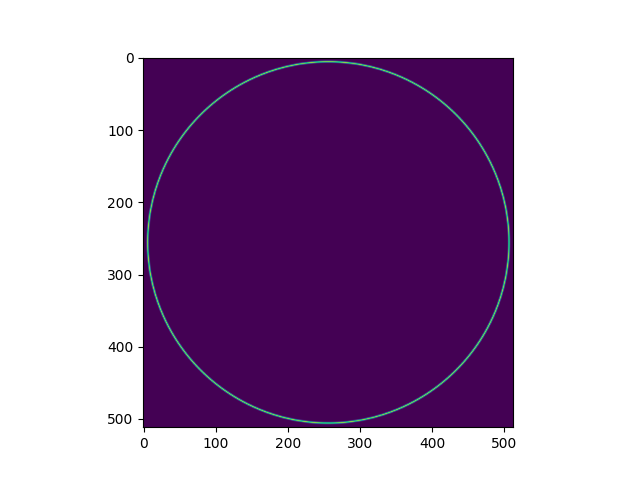

In [15]:
plt.imshow(obj)
plt.show()

In [47]:
refstack = np.array(allbeads_refstack["Refstack"])
masks = np.load("masks_discrete.npy")
z_stack = np.zeros((len(refstack), refstack.shape[-1]//2))
for i,ripple in (enumerate(tqdm(refstack))):
    for j,mask in enumerate(masks):
        z_stack[i,j] = np.median(ripple[mask])
np.save("z_stack.npy", z_stack)

 19%|█▊        | 292/1568 [00:03<00:14, 88.47it/s]


KeyboardInterrupt: 

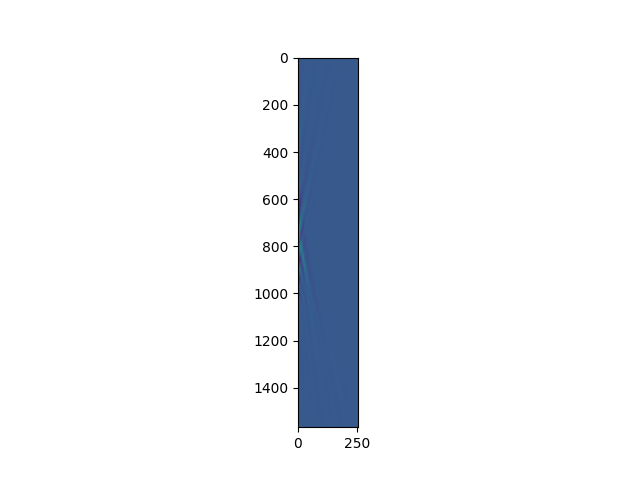

In [31]:
plt.imshow(z_stack,vmin=1.8e4)
plt.show()

In [369]:
def xy(z_stack,z):
    z_stack -= np.min(z_stack,axis=0)
    z_stack /= np.max(z_stack,axis=0)
    ripple = np.zeros((2*z_stack.shape[-1],2*z_stack.shape[-1]))
    for r, val in enumerate(z_stack[z]):
        ripple += val*masks[r]
        # print(val)

    return ripple

In [24]:
import h5py
allbeads_refstack = h5py.File("FinalRefstack_allbeads_latdrift_corr_min20_temp.mat")
refstack = np.array(allbeads_refstack["Refstack"])
# refstack = refstack.astype(np.float32)

In [34]:
allbeads_refstack.keys()
allbeads_refstack["horz_position"]

<HDF5 dataset "horz_position": shape (63, 1001), type "<f8">

In [103]:
masks=np.load("masks.npy")
masks=masks/masks.sum(axis=0)
outside = np.isnan(masks)
masks[outside] = 0

z_stack = np.zeros((len(refstack), x0))
masks_normalized = (masks.T/masks.sum(axis=(1,2))).T
for i,ripple in (enumerate(tqdm(refstack))):
    for j,mask in enumerate(masks_normalized):
        z_stack[i,j] = np.sum(ripple*mask)
np.save("z_stack.npy", z_stack)

/var/folders/39/51hl1qv962dgjs7r9mznnsxm0000gp/T/ipykernel_18323/1601726769.py:2: RuntimeWarning: invalid value encountered in divide
  masks=masks/masks.sum(axis=0)
100%|██████████| 1568/1568 [00:32<00:00, 47.84it/s]


In [209]:
z_stack = np.load("z_stack.npy")
masks=np.load("masks.npy")
masks=masks/masks.sum(axis=0)
outside = np.isnan(masks)

/var/folders/39/51hl1qv962dgjs7r9mznnsxm0000gp/T/ipykernel_18323/1246482713.py:3: RuntimeWarning: invalid value encountered in divide
  masks=masks/masks.sum(axis=0)


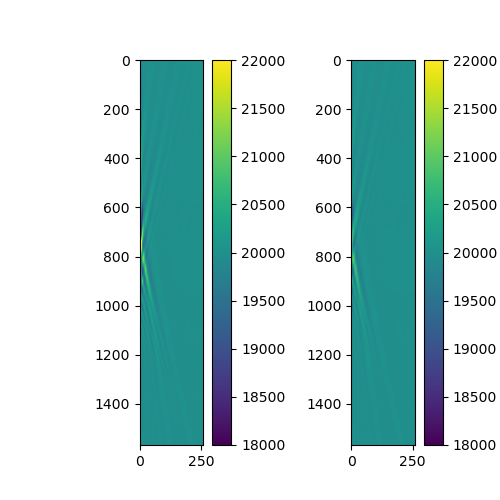

In [202]:
np.arange(len(test[i])-10).shape,np.convolve(test[i],np.ones(10)/5,mode="valid").shape#

((249,), (250,))

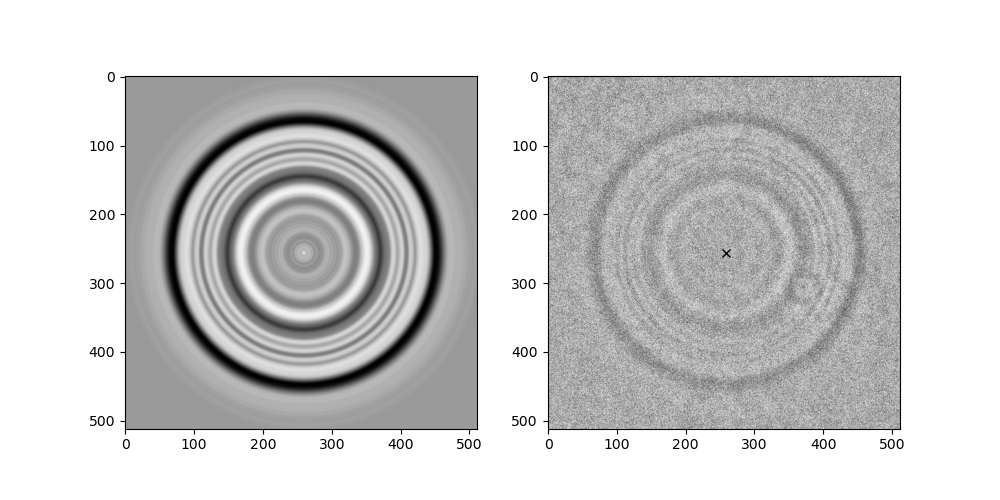

In [210]:
from matplotlib import colormaps as cmaps
def averaged_z_stack(z):
    ripple = np.sum([(masks[i]*z_stack[z,i]) for i in range(len(z_stack[0]))],axis=0)
    ripple[outside[0]] = 2e4
    return ripple
plt.close("all")
plt.figure(figsize=(10,5))
z=1500
plt.subplot(1,2,1)
plt.imshow(averaged_z_stack(z),cmap=cmaps["Greys"])
# plt.imshow(masks[100],cmap=cmaps["Greys"])
# plt.imshow(np.isnan(masks).sum(axis=0))
plt.subplot(1,2,2)
plt.imshow(refstack[z],cmap=cmaps["Greys"])
x0,y0=np.array(refstack[0].shape)//2
plt.plot(259,y0, "kx")
plt.show()

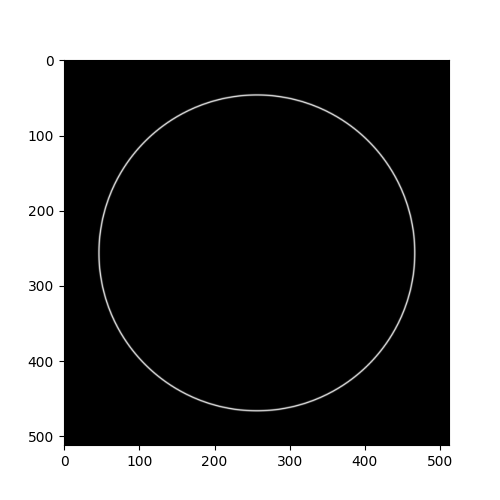

In [191]:

plt.figure(figsize=(5,5))
plt.imshow(masks[210],cmap="grey")
plt.show()

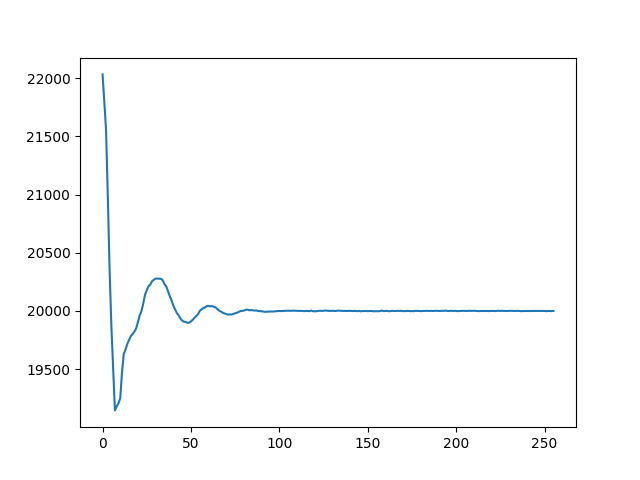

In [76]:
z_stack_interp = interp1d(np.arange(len(z_stack)),z_stack)


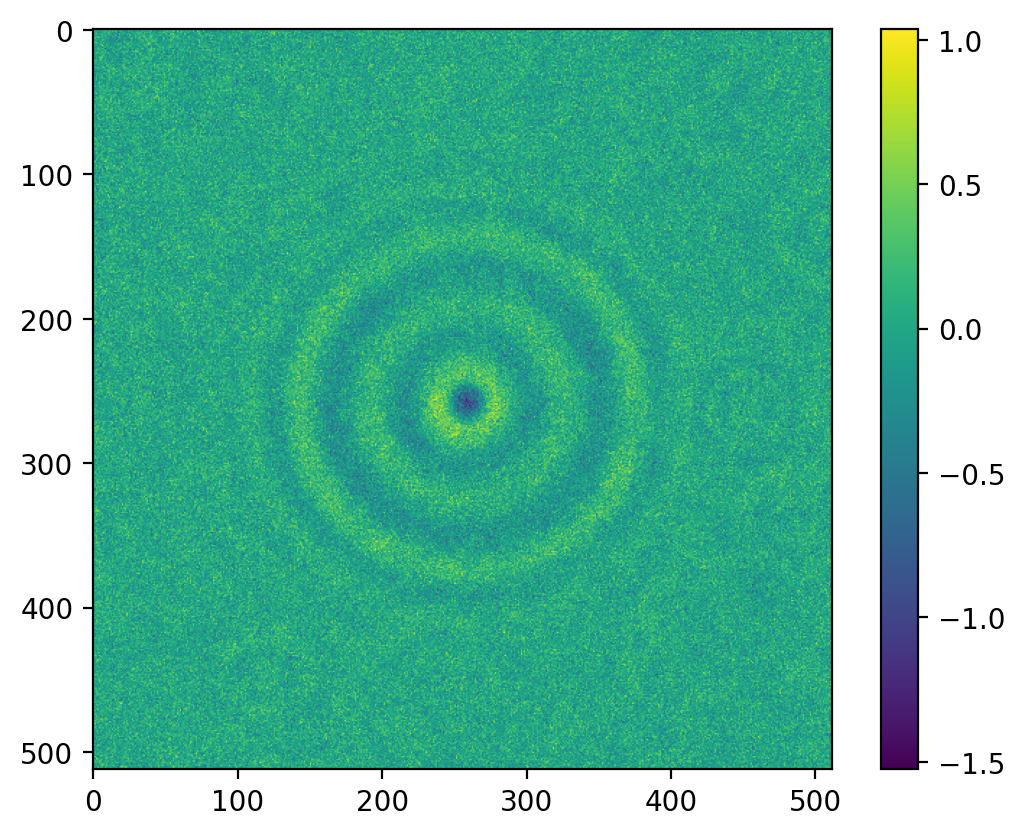

In [405]:

plt.imshow(refstack.T[200])
plt.colorbar()

In [6]:
from scipy import io
from h5py import File
import numpy as np

In [7]:
psf = File("../../../Documents/testpsf.mat")

In [15]:
psf["data"].keys()

<KeysViewHDF5 ['aLimits', 'cmap', 'comment', 'created', 'det', 'fullRange', 'history', 'id', 'ill', 'logValues', 'masterA', 'masterX', 'masterY', 'masterZ', 'name', 'nx', 'ny', 'nz', 'property', 'showColorbar', 'showFWHM', 'showGrid', 'showLocalMin', 'showLocalWidth', 'showMax', 'showMin', 'structVersion', 'undistorted', 'xLimits', 'yLimits', 'zLimits']>